# Importando as bibliotecas

In [1]:
import numpy as np
import cv2
import imutils
from matplotlib import pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def mostrar(img):
  fig = plt.gcf()
  fig.set_size_inches(20, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

# Processamentos na imagem

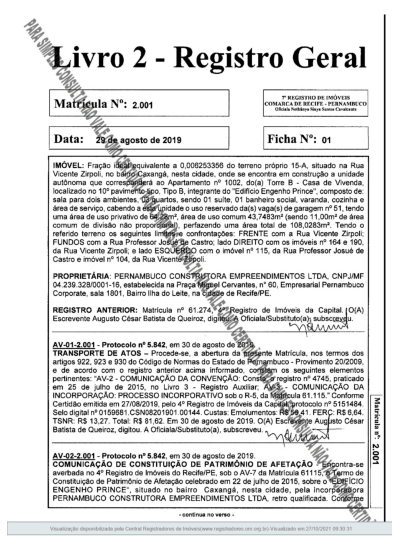

1755 1240


In [3]:
img = cv2.imread('') #Caminho relativo da imagem
original = img.copy()
mostrar(img)
(H, W) = img.shape[:2]
print(H, W)

## Ajustes de brilho e contraste para retirar a marca d'agua

In [4]:
original = img.copy()
(H, W) = img.shape[:2]

# Pré-processamento e filtros
# Ajuste do brilho e contraste para retirar a marca de agua.
brilho = 200
contraste = 100
ajustes = np.int16(img)
ajustes.shape

ajustes = ajustes * (contraste / 128 ) - contraste + brilho
ajustes = np.clip(ajustes, 0, 255)
ajustes = np.uint8(ajustes)

## Escala de cinza

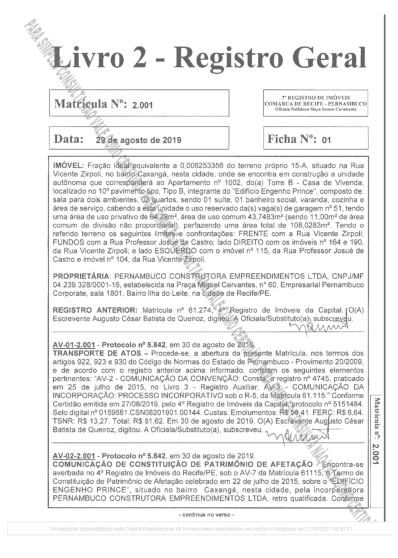

In [5]:
gray = cv2.cvtColor(ajustes, cv2.COLOR_BGR2GRAY)
mostrar(gray)

## Limiarização com método Otsu (*thresholding*)

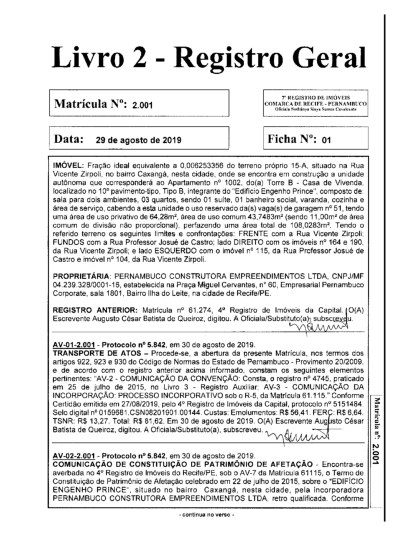

In [13]:
val, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
mostrar(thresh)

## Aplicação de desfoque (*Gaussian Blur*)

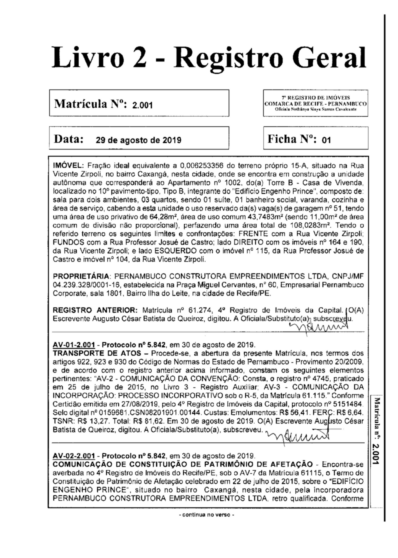

In [14]:
blur = cv2.GaussianBlur(thresh, (5, 5), 0)
mostrar(blur)

## Detecção de bordas (*Canny Edge*)

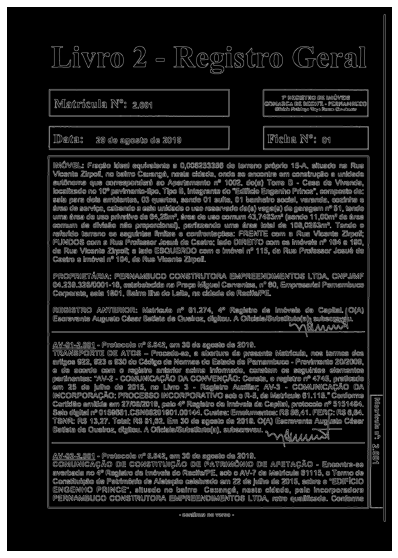

In [15]:
edged = cv2.Canny(blur, 60, 160)
mostrar(edged)

## Dilatação das bordas

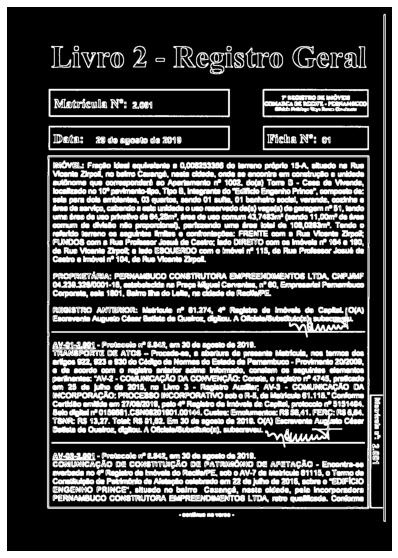

In [16]:
dilatacao = cv2.dilate(edged, np.ones((3,3), np.uint8))
mostrar(dilatacao)

# Detecção de contornos na imagem

In [17]:
def encontrar_contornos(img):
  conts = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sorted(conts, key = cv2.contourArea, reverse = True)[:6]
  return conts

In [18]:
conts = encontrar_contornos(dilatacao.copy())

## Localizando o maior contorno

In [19]:
for c in conts:
  perimetro = cv2.arcLength(c, True)
  aproximacao = cv2.approxPolyDP(c, 0.02 * perimetro, True)
  if len(aproximacao) == 4: #Alterar para a quantidade de Vértices (alternativa ">=4")
    maior = aproximacao
    break

maior

array([[[ 131,  479]],

       [[ 130, 1617]],

       [[1165, 1618]],

       [[1166,  479]]], dtype=int32)

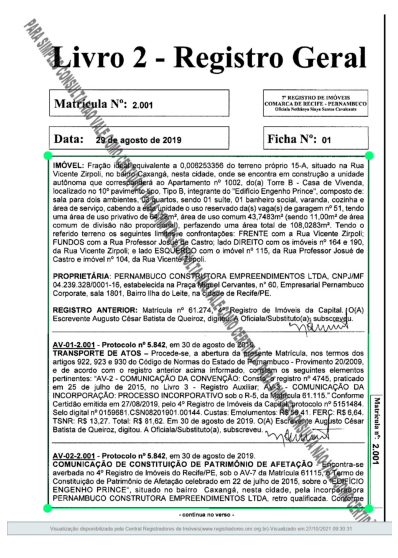

In [23]:
cv2.drawContours(img, maior, -1, (120, 255, 0), 28)
cv2.drawContours(img, [maior], -1, (120, 255, 0), 2)
mostrar(img)

## Ordenando os pontos

In [24]:
def ordenar_pontos(pontos):
  pontos = pontos.reshape((4,2))
  pontos_novos = np.zeros((4, 1, 2), dtype=np.int32)

  add = pontos.sum(1)
  pontos_novos[0] = pontos[np.argmin(add)]
  pontos_novos[2] = pontos[np.argmax(add)]

  dif = np.diff(pontos, axis = 1)
  pontos_novos[1] = pontos[np.argmin(dif)]
  pontos_novos[3] = pontos[np.argmax(dif)]

  return pontos_novos

In [25]:
pontos_maior = ordenar_pontos(maior)
print(pontos_maior)

[[[ 131  479]]

 [[1166  479]]

 [[1165 1618]]

 [[ 130 1617]]]


In [26]:
maior

array([[[ 131,  479]],

       [[ 130, 1617]],

       [[1165, 1618]],

       [[1166,  479]]], dtype=int32)

## Matriz de transformação

In [27]:
pts1 = np.float32(pontos_maior)
pts2 = np.float32([[0,0], [W, 0], [W, H], [0, H]])

In [28]:
matriz = cv2.getPerspectiveTransform(pts1, pts2)
matriz

array([[ 1.19925465e+00,  1.05382659e-03, -1.57607143e+02],
       [ 9.75015761e-17,  1.54235321e+00, -7.38787190e+02],
       [ 8.49113284e-07,  1.49163603e-09,  1.00000000e+00]])

## Recorte

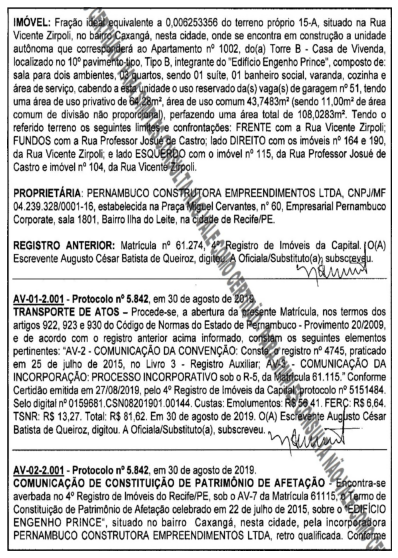

In [30]:
transform = cv2.warpPerspective(original, matriz, (W, H))
mostrar(transform)